In [ ]:
! pip install gym torch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib.pyplot as plt

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
      super(Actor, self).__init__()
      self.state_size = state_size
      self.action_size = action_size

      self.network = nn.Sequential(
          nn.Linear(self.state_size, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, self.action_size),
          nn.Softmax(dim=-1)
      )
      self.optimizer = optim.SGD(self.network.parameters(), lr=0.005, momentum=0.70)

    def forward(self, state):
      if not torch.is_tensor(state):
        state = torch.from_numpy(state)
      distribution = self.network(state)
      distribution = torch.distributions.Categorical(probs=distribution)
      return distribution




In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
      super(Critic, self).__init__()

      self.state_size = state_size
      self.action_size = action_size

      self.network = nn.Sequential(
          nn.Linear(self.state_size+self.action_size, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 1)
      )
      self.optimizer = optim.SGD(self.network.parameters(), lr=0.005,
                                 momentum=0.70)

    def forward(self, state, action):
      state = torch.from_numpy(state)
      action = torch.from_numpy(np.array(action))
      return self.network(torch.cat((state, action)))

In [ ]:
# class ActorCritic:
#   def __init__()

In [ ]:
BATCH_SIZE = 32
MAX_BUFFER = 10000
MIN_BUFFER = 1000

In [ ]:
class Agent():
  def __init__(self, env):
    self.batch_size = BATCH_SIZE
    self.memory = list()
    self.max_buffer = MAX_BUFFER
    self.min_buffer = MIN_BUFFER

    state_size = np.prod(env.observation_space.shape)
    action_size = env.action_space.n

    self.actor = Actor(state_size, action_size)
    self.critic = Critic(state_size, action_size)

  def get_actor_output(self, state):
    dist = self.actor.forward(state)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob

  def get_actor_outputs(self, states):
    dists = self.actor.forward(states)
    actions = [dist.sample() for dist in dists]
    log_probs = torch.log(dists)
    return actions, log_probs

  def get_q(self, state, action):
    return self.critic.forward(state, action)

  def update_buffer(self, current_state, action, log_prob, reward, next_state,
                    is_terminal):
    self.memory.append({
        "current_state":current_state,
        "action":action,
        "log_prob":log_prob,
        "reward":reward,
        "next_state":next_state,
        "terminal" :is_terminal
    })

    if len(self.memory) > self.max_buffer:
      self.memory.pop(0)

  def train(self):
    if len(self.memory) < self.min_buffer:
      return

    indices = np.random.choice(len(self.memory), self.batch_size, replace=True)
    batch = [self.memory[idx] for idx in indices]

    states = torch.tensor([b["current_state"] for b in batch], dtype=torch.float32)
    actions = torch.tensor([b["action"] for b in batch], dtype=torch.int64)
    log_probs = torch.stack([b["log_prob"] for b in batch])
    rewards = torch.tensor([b["reward"] for b in batch], dtype=torch.float32)
    next_states = torch.tensor([b["next_state"] for b in batch], dtype=torch.float32)
    terminals = torch.tensor([b["terminal"] for b in batch], dtype=torch.bool)

    next_actions, _ = self.get_actor_outputs(next_states)

    q_vals = self.get_q(states, actions)
    next_q_vals = self.get_q(next_states, next_actions)

    targets = rewards + GAMMA*next_q_vals
    deltas = targets - q_vals

    actor_obj = -(log_probs * deltas.detach()).mean()

    self.actor.optimizer.zero_grad()
    actor_obj.backward()
    for param in self.actor.parameters():
        param.grad.data.clamp_(-1, 1)
    self.actor.optimizer.step()

    critic_loss = nn.MSELoss()(targets, q_vals)

    self.critic.optimizer.zero_grad()
    critic_loss.backward()

    for param in self.critic.parameters():
      param.grad.data.clamp_(-1, 1)
    self.critic.optimizer.step()


In [ ]:
env = gym.make('CartPole-v1')

EPISODES = 1000
GAMMA = 0.995
scores = []

agent = Agent(env)

for e in range(EPISODES):
  state = env.reset()
  terminated = False
  score = 0

  while not terminated:
    action, log_prob = agent.get_actor_output(state)
    next_state, reward, terminated, truncated = env.step(action)
    agent.update_buffer(state, action, log_prob, reward, next_state, terminated)
    agent.train()
    score += reward
    state = next_state

  if e % 10 == 0:
    print("Episode "+str(e)+"/"+str(EPISODES)+", Score: " + str(score))

  scores.append(score)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0/1000, Score: 24.0
Episode 10/1000, Score: 16.0
Episode 20/1000, Score: 26.0
Episode 30/1000, Score: 22.0
Episode 40/1000, Score: 19.0


RuntimeError: ignored

In [ ]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

In [ ]:
scores = [-204.1117329384312, -197.42221664475557, -133.7271816580856, -128.27520963022044, -341.587061103265, -371.10385057737403, -125.13025199437735, -91.71459109090802, -129.1525130403436, -161.92400638337705, -93.76770152728594, -304.2147428765303, -160.41296442319913, -296.95789738985934, -72.30815355932035, -188.21519331986696, -146.25676431008375, -394.67526767137434, -162.88910069489924, -193.73456782890435, -174.5325211078482, -120.10623766146209, -217.66039305138293, -149.44316290249247, -392.163345393986, -77.8628190344054, -321.8714150121824, -357.2633336822401, -221.91529852646724, -313.21198123906345, -103.10508623082974, -108.95607750056203, -180.15494374182816, -88.12255223202772, 16.84023119578525, -110.32894247141351, 12.005231208278815, -198.71720462479422, -143.51792185147997, -85.30707851634823, -125.63473858688386, -159.24076048061573, -123.61428349842858, -206.6759358461923, -244.54125285604266, -355.1047551320178, -247.8733013483771, -407.5712999678701, -369.2135954704724, -149.31606542143555, -120.30464407800761, -199.86190146583948, -269.89656949283426, -171.5957356981121, -124.99453668197981, -122.26020822106247, -263.9972593132843, -133.40025890024884, -86.88689055897774, -90.71794029525842, -156.0150278328974, -90.9397799730584, -171.94993101990391, -153.6771336938751, -304.4210988229455, -86.33162333152224, -234.33461896558802, -454.6009141305831, -189.35091528856643, -116.99538238216009, -153.8449745804523, -121.7675047162589, -141.19007393606626, -78.03216784866467, -123.32645863429391, -81.17222467456325, -87.96403026686686, -250.4663439588706, -124.03796369045035, -136.27278939554475, -119.76972359564672, -108.8282747315645, -165.50056258413076, -147.78948907936365, -107.20490991714603, -184.68800697595478, -128.3303037308002, -158.06026101436152, -144.70785088673324, -109.66868164569321, -352.5821098964019, -109.47728510493411, -232.52804125286858, -65.2460803215483, -116.53101326297636, -90.53389448873787, -54.14959718105419, -113.7645973357316, -99.71691323965868, -138.38902019248232, -177.26347388410704, -78.32615146462484, -182.56914978908168, -127.31303796990613, -262.6343097863436, -196.29108500254003, -201.46324006253832, -229.97048104872772, -193.27950533223236, -83.69143529471603, -81.16861739581509, -49.934189739558235, -218.4550765075084, -144.02538079872465, -76.40621230442484, -99.17318503764893, -69.33936377325327, -132.90635583670607, -131.10210394935868, -186.31665550918638, -107.78634304326299, -84.25007629246039, -118.36219986229301, -238.920791848486, -127.05399305872322, -246.7648297117089, -131.68895393357485, -236.42165576334386, -94.68216095366502, -81.77543568694948, -121.32617292520969, -95.76817949014324, -135.86279057568296, -235.5591418256685, -100.54623439104827, -116.1136316533742, -146.40218515799847, -131.62659616345678, -162.55722154962268, -94.02950097532721, -95.10689444219297, -104.84973192647828, -84.2391909583962, -165.12940615282122, -80.93879923323364, -145.48646374820598, -71.92744684590951, -171.1059496903868, -145.84601605491645, -74.48219546759003, -118.88782090247146, -79.61774341196961, -293.4727731740096, -87.93737947040226, -109.82942927213881, -133.22308714023407, -153.65544321918276, -107.77879254918923, -179.8044833259118, -104.83920237093187, -41.83245642840295, -238.7001294085893, -114.77923283451543, -113.13993665636781, -165.45575216255054, -96.17949045028172, -90.692866928752, -67.28855157805842, -116.95054504855953, -98.38037056068757, -118.87607951048717, -72.30271636529062, -81.29425809893746, -109.78089551711066, -129.5582066483435, -98.62658454322091, -61.309576208166355, -95.14596059214611, -101.04942591962288, -100.91729899138501, -123.16406569316351, -112.32148492914204, -173.5910433542893, -88.54389951370227, -229.40626034878682, -115.52839910511418, -96.22118098483634, -96.37841427201849, -39.827132599109135, -174.37877746321098, -122.01701512148372, -166.19377996365432, -71.12895010262353, -166.64541600900574, -37.43340693707671, -128.3353198602881, -181.3791006155015, -89.49603007146573, -88.32134706445719, -80.37927186235657, -74.32839160704202, -231.94091266913358, -67.53072302037394, -64.70956660538839, -208.37064269968153, -65.37395036227694, -101.3692585874377, -102.78295687174734, -104.02410595305899, -138.17848418686452, -101.90231094129895, -97.94312974545431, -293.37499352887323, -91.58451314885426, -268.7185774232421, -143.17726683654615, -58.94795166079934, -120.20996239285492, -145.80470946694965, -62.83562034915757, -79.53607164076783, -181.07820196574778, -49.4405371498822, -110.27381091115869, -62.537192485408916, -113.14124008229777, -125.63319443335413, -162.86886217293312, -72.89809985036237, -69.02456022988171, -121.54531210703536, -122.18598224670329, -83.67569841451997, -90.49275247168596, -23.589599130632777, -43.17031427181758, -54.07522411292433, -89.68603346668627, -67.33714107567853, -98.53917225313316, -8.456157022849453, -166.08987678212873, -201.88377268495594, 28.7281194288513, -59.15886311163658, -18.589609402433325, -40.369740436363244, -52.67204638355116, -30.26518341002088, -71.1748018181666, -35.206559602373204, -63.03573821246093, -54.931502496745004, -29.950659935074114, -66.92706649546703, 20.59063268171718, -18.850607969940313, -57.69073810626776, -78.56848892771087, -74.1562247611556, -10.2801633384329, -77.41842566768233, -47.422579130709046, -19.48550520744999, -14.072487006774168, -13.505199398976742, -82.7891783981257, -80.3840543965627, -63.88161989400244, -44.958736375932205, -124.50808870262955, -148.5536605057444, -57.15929776774102, -114.71798481527901, -49.094749171775355, -14.745893012451617, -58.324180251411875, -23.873013720374118, -65.68897497266808, -51.36112082388334, -33.6562157859061, -123.454570342886, 11.20334223650454, -7.316855907752796, -97.96310035399937, -40.647726346136025, 47.82225839292977, -22.40322140044492, -60.90615336715808, -7.124039805587913, -15.210955794038512, -51.62240642108262, -63.345793161974974, -68.98373970116748, -33.50613785275205, -2.4043957665718807, -68.53148773024714, -1.938637528480342, -106.44180879165825, 0.5665791854138718, -159.27477079974054, -72.69028740647403, -51.58107898495633, -29.114572151630384, -141.28119434712337, -66.64143388523516, 33.145839508569956, 35.276579724022014, -44.41711136335917, 0.17479909595033405, -118.74231152062117, -47.278476468560356, -78.34406495141305, 44.180836387974495, 18.22020807178862, 24.582006433834284, 0.005589493577758731, -184.4920759168221, 47.23831942139404, 4.226569890368864, -91.53693440072445, 41.18430151233497, -16.252794260622764, -18.32571918186227, -266.73213868325297, -63.29777673728766, 26.162839812011413, -114.95966180577686, -50.49088441483326, 0.5137890564843559, 15.641643747010491, -11.845368225446105, -19.41449005080422, 31.050291462157787, -60.80762003910901, -45.19950460062919, -44.546710377247365, -19.27625623611135, -50.509508017807065, -18.068020354849835, -63.893175473319225, 4.146942715169843, -77.84468511105459, -1.6988546830146163, -33.956272774075785, -41.34378044262006, 2.9958970604277084, 2.4170388568018097, 53.977040590026036, -130.22709708513835, 6.185814864049661, -46.54215281727819, 9.45943511992212, -76.1949748173734, -49.13808865105106, 48.58547420830223, -61.6555518281606, 15.809121805518075, -24.37878588192885, 21.528928674897074, -15.917776803123502, -113.1090205460194, -27.280013674053933, -277.78238721396133, 21.730854970354187, -23.789776667060536, -110.78836306985028, 13.256544390388257, -26.700458224360474, -124.2393576746365, -33.06187195892264, -11.344678069150861, 12.824570796444021, 52.157508973722656, 14.557521579605883, -24.147240024382814, 16.35208151109819, 14.583261321856098, -198.31083288165476, -31.929145448960085, -33.16567290125383, -213.14288464546422, 1.0840971066038492, 8.106049863806518, -1.3902774364197228, -44.84677081570275, 50.77496178441311, -6.6677602768214115, 11.111622770482015, 30.901475133156964, -26.09482869161431, -5.347271834627733, 48.08145337286908, -29.880838659705063, -28.963216913130026, 25.984618014094735, -6.660111080049148, -5.389010357206487, -22.864522712428624, -0.10419993285228202, 8.437755329430601, -28.312352131409185, 9.485709085736204, -55.077730470949604, 19.045847672839074, -53.03775161568025, -44.752235960891554, -42.38658131502733, -19.757549696722748, -14.91600711262322, 19.704396662243738, 25.12531727810473, 23.208091534031155, -8.20897510354699, -15.529281025100005, -24.12333369722272, -20.774369265633297, -5.3409234524738025, -18.090915009046412, 17.911412947467497, -4.835715969700928, -4.55342995496521, -7.920646747452423, 4.265808098082815, 14.506016471319725, 3.3878877221423096, 7.3952293992544895, 36.30730325114965, -21.279082385025305, 19.53461688007006, -13.31026854220525, 49.039679831803596, 3.8637664803980933, 16.9069778110522, 44.16768671624595, -28.020759324555158, 46.36525717068105, 9.39228575125891, 21.698839034927843, -37.13632335103735, 28.461691249045316, 22.31856139487836, -90.06796221969259, -14.62214941414507, -3.244824805411561, 15.02747905950785, -80.7756316144605, -56.63500551840622, -151.15713652180156, -43.092363442722046, 28.41783712029088, 6.2837226175438445, 7.473439514988002, -54.447217293121554, 1.2773001478364863, 29.358562810137585, 7.293483995495445, 14.690558144995384, -56.70632707986297, 0.18538234428447714, -257.2099854567423, -24.143799846469165, -23.9271028472527, 29.157725457551393, -51.983829384500574, 27.34239319191765, 26.573132734181744, 0.796140798221117, 17.83938757894795, 29.349910134937602, 31.846156656945766, 33.49352362447854, 20.069411254550218, 1.9620352700509045, 8.729934419354997, -17.58933354714179, -5.889686968995932, 46.67730943146922, -38.45644738965987, 50.75641318858288, -6.108888543463962, 31.085917736210888, 43.61622927344837, 16.310369646642243, 1.6498429335885305, -64.09245697270038, 12.010823652963339, 34.74924585541635, 0.529435680783152, -24.374208103366882, 6.290744370144708, -2.0992413723211882, -35.75499111549182, -19.596807870185103, -7.893987432878319, -49.83110143793576, -53.65718841653971, -35.32930104922217, -4.098028901984307, 60.31930570276421, 45.29305085280569, 42.96489916327337, -34.30061744127853, 23.687208378925234, -321.9221153957351, 50.704107119959595, -26.800332422729653, 48.26125373431538, 46.02278518187609, 39.27472353478754, -6.800214439718866, 38.66511428544237, 34.731728157696445, -25.679514989997514, -5.066875760844207, -21.062459651443124, 9.898624539960075, 28.879988555954128, 7.774798868084884, 17.929886566792053, 21.086526500870036, 3.4282856520723057, 42.243339254772565, 54.340319363818935, -8.53396698945417, -8.624202212465256, -59.93868860590426, 9.568877805035067, -7.668527383992483, 13.683411328839327, -242.31635628295984, -46.753022247174655, 9.084312274160514, -112.79720993858886, -20.733551178095528, 12.892645463447755, -14.142880003765669, 16.496156190410368, -61.69684314405671, -281.3673661429173, -8.086984346328617, -254.30678645393252, -53.96164854902332, -316.25735288392434, -29.746845362332557, -94.1329967316085, -90.00231107507594, -20.806695946886574, -32.23578357494574, -8.84870830585831, -24.207619150662136, 0.19796970669507785, -19.101939464398768, -87.56614563666963, -68.97338518426521, -61.36446359805157, 7.153054363711056, 49.61478406983812, -81.95454270762268, -51.25276305597542, 8.644362260283314, -32.549103960402505, -82.01400481192692, 77.54952651049348, -0.6995470424638768, -69.54315458566525, -38.52888067135245, -20.501600718894576, 4.120950594876953, -17.641460790273868, -35.96619949796549, 6.357202240323346, -48.13603210061021, -26.832135056249975, 42.98122334853067, 12.912989358647094, 28.492569285221364, 14.883864194828282, -54.78124294373494, 34.20963004892767, -1.680225421502666, 16.567668445040223, -11.901646101302989, 16.055543519070824, -4.583415914493531, 46.43644235108164, 12.053806837404162, 20.855837236843854, -7.614172817225381, -106.38359990612597, -11.213939254529782, -48.54773794060003, 11.367786563282555, -10.787924257734119, -20.883831238886224, -11.191011727810755, -20.844576643820506, -1.2286189259851028, -37.43106747523467, 18.016944610734267, -56.760093303173406, -20.203299856364797, -30.367703657528978, 52.48735542006814, -257.51435252603824, -15.620038419767074, -22.164656121911918, -82.28434264054734, 19.116952667987295, -354.8866827579425, -4.632953300343553, -197.95136718485486, 2.9686737059338313, 21.73654727587889, 15.120163076273368, -6.58767879223447, -299.83649827496515, -69.6698389467606, 45.00707336009615, -46.378473572446154, 11.30024693468355, 42.252430606788224, 54.249164384451305, -228.71321598621824, 19.534476016537354, 67.47022066792563, 30.000797874310763, 62.49527076834815, 34.92538952406997, 7.721573450063303, 73.74404095046201, 19.755081198067174, 64.39095918531379, 37.48376248667151, 33.35132045115327, 13.168851051055483, 72.15291288391228, 46.73920646598143, 11.785029164770478, 3.596594822620369, 47.73923072519037, -5.777695058133125, 57.96566545653348, 13.842286136445779, 38.73112519676138, 22.94180897748751, 31.09647355602732, 56.226636849809886, 61.459551816957486, 20.989619339808403, 80.81347788053436, 96.55127989974433, -140.23564232657662, -4.821479417697915, 56.95954824221228, 18.64281234136415, 49.800827593685966, 35.869800666854765, -24.889101893549565, 39.57104852458781, 51.08273788681852, 26.344547499619193, -204.37173555579767, 57.19306870276983, 15.314893748980225, -29.75487056831915, 0.8470080522409162, 17.231209992095962, -4.089471572476455, 1.00472090698654, 52.540779487406304, 29.689977430536317, 15.07722294726701, 8.57655438076925, 8.932439260250149, -179.19455249648783, 42.79544484628825, 2.9513623240913063, 48.8517070431229, 10.624884059553692, -4.5497946928519895, 27.79121145178898, 41.65436620257347, 50.227427515519395, 49.27027159472566, 40.89432163634601, 7.644359853691395, 52.775399436581665, -4.048633073818092, 6.2042244802469355, 43.581273273404854, -6.459083183029017, 42.6284818989612, -197.9838654208384, 11.65782846983673, -13.322158774896067, 65.09788063966684, 45.24083026502571, 13.79573421395822, -80.00112348357462, -9.848641038601919, 7.363402681065504, 9.622429593869796, -22.916615445052436, 38.29657904214766, 25.441820291977525, 25.780506934795195, -2.247102347737923, 29.277407267366087, 15.163957751566656, -11.036952477285158, 29.971198132517582, 51.55441213171903, -4.8702046926871585, 1.530674723336564, 68.55665832003463, 40.05337201169229, 49.249641459819436, 24.68375419689891, 0.07770751357530692, -10.51592317121727, 39.78377180350756, 15.086103571257194, 7.889434554208694, 13.263881811949238, 7.1795224922310235, 73.59944441048151, 46.00979555363817, 15.183252789412244, -184.7194835181086, 16.731249004641402, 68.41844134081431, 11.871266268914349, 12.494324329286396, 31.562045078533785, -8.205324983713615, 14.62971033089476, 46.42280093900668, 37.959817352398, 86.06751541717585, 30.334165464924638, 9.755673053691918, 48.43988976726624, 4.372134047203119, -17.477268099715598, 25.220944807741866, 25.88610227899825, 28.379667280810366, 33.202016897422425, -18.551470117725216, -25.760773769464326, 24.85180957234671, -10.484026428066567, 28.937524194241735, 37.561092127741, 44.625065790347264, -19.228801694871844, 60.614109665441305, 27.753217236955933, 33.978245224131754, 55.223400117057814, 5.548433654002295, 4.374682901790071, 83.64957602006291, 48.37144070642216, 59.09688041705914, 25.430260803347167, 18.89779972609155, -4.041382053331917, -67.31276395899624, -7.556965815195067, 59.158451383833615, 36.33534691021173, 18.549371363145518, 13.013427101097687, 71.19242719763604, -4.887931754394728, 4.756082407623975, 29.463480895950802, 81.0036765833465, 39.70633035195261, 5.5740219311475965, 28.344510076217503, 29.308831093612742, 29.383115282400052, 45.62231840301804, 49.077597854494094, 41.36369025760082, 40.2738375272207, 56.698556036338864, 28.14568970967991, 13.469285331377385, 31.575408871733476, 18.386432423597057, 26.48129535387669, 50.033536139863884, 39.450127850816074, 35.11113231559642, -18.88468029548019, 56.461656297623136, 28.15190629600323, 48.86300758526645, 35.40899686063334, 74.02387886112106, 57.914740368435176, -18.491289912684344, 30.93672656731436, 49.303449542140214, 62.45253069528341, 18.10200582595012, 1.701304639680099, 44.017305811995136, 26.34297155059285, 52.5582987730379, -6.063027996201001, 49.87644900417795, 40.840667573543975, 85.04164078620346, -3.3529159107815323, 50.8175113953505, 38.06771773615504, 8.168817161396387, -85.04211816906391, 63.94849918221889, 28.049221285635113, 18.170517731676885, 51.25035910498223, 30.236934043496902, 54.15311861832514, 7.303422807283343, 42.233661703565424, -126.40201075637444, 75.10358581007823, 14.78516390811032, 66.76784496328958, 53.11705165702397, 50.4678031032691, 60.405756859103185, 35.829551000064015, 43.11021565976667, -1.02451084207379, 65.14842287542396, 21.471008243248775, 58.45242596207406, 44.02223303463538, 19.150076063834362, 20.506465900371225, 77.59488586743868, 36.824542542851304, 22.33710107019279, 77.79898253567808, 65.04780285313477, 38.728436568296516, -21.775206756477246, 36.35439649903668, -15.62222907895071, 35.916363947259725, 6.5394762590407485, 43.55690573048339, 49.75628122034735, 53.2269948099525, 33.614202917412484, -30.36373520130782, 12.686976113717467, 19.326481898310334, 43.457942451934755, 63.064474387177185, 14.430617785480523, 26.164104635434143, 60.627524834750496, 31.67977393533347, -15.467471315861758, -25.906236586075494, 47.31357609545877, -2.7844055138037573, 46.61285407576644, 33.579527582025065, 57.03899526669822, 27.30241900821366, 18.672604405423296, 0.6586893712597996, 76.32767926042501, 50.42359615421127, 54.434134720318816, 28.43866400938848, 11.14199913339886, 29.719226257207737, 24.71455359729095, 85.7400499421116, 49.05836798907333, 38.83865838602286, 56.24805055382337, 53.618038500892055, -11.675792949489077, 57.05728381489785, 5.911101554317992, 7.812145375853223, 43.6751403808733, 55.00282733453205, 38.22095808710222, 24.425875880878607, 32.298797520065456, 36.16608459984735, 31.459750354021203, 31.34439256094356, 35.352552127608334, 67.5918221387102, 58.81635517039166, 18.561169608850783, 71.61318472718506, 16.004799058565492, 68.13761072664737, 81.5490285032226, 49.64098271083425, 29.585818126359207, 55.009143810223065, 64.04027713548518, 11.227019088055934, 54.47450000692194, 46.55873883307406, 10.249591100121778, 58.103576855704794, 15.728350986157228, 40.75030190959618, 63.37105000019011, 72.05197049949227, 101.30261357824568, 74.70682865060567, 83.06164425390072, 2.134072107386487, 31.093386688192822, 79.22900511967906, 63.433648069928395, 9.570076912887089, 58.19029593965391, 41.60143154697559, 45.16143706849092, 63.494233682334134, 73.16638554313776, 43.5126533074465, 52.42021117879843, 76.31504309983309, 68.47042663803163, 25.573179774296094, 28.429360163838986, 10.160506920258186, 36.07808583742451, 56.04949435381624, 62.836011364782834, 106.08853022765096, 48.379682080424644, 24.069477337614718, 61.99617216106978, 9.860470709493727, 48.33414990633567, -8.664059975208625, 22.499802914147647, 85.86801933145732, 18.048030077434248, 54.70319690936624, 19.216483335379394, 59.574376911909084, -11.525512604041856, 36.00032267657684, 73.15117015639922, 3.3688210231192124, 0.6962687875581641, 13.532844572106818, 20.840684123193245, 17.47698481647777, 47.218578129244854, -27.69768874207038, 62.10815158706407, 61.91220739820564, -68.44246780063864, 8.162536265853168, 30.825800113864755, 60.98663382311972, -4.07720075499568, 53.27100500520503, -13.527311902351963, 36.61621672874129, 64.09152950026609, 25.527620855328642, 44.4536183440365, 13.393717175848998, 48.82963302530083, 43.06474823837256, 25.636271105183617, 35.46473200488732, 4.437947746728277, 44.112732204520526, 53.49358394744056, 81.82630010396008, 48.389967105885006, 51.58411591940348, 28.9398365988675, 25.575380193734347, 43.364902152185266, 20.198711522260552, 20.941312086222457, 47.01537376913241, 43.71339318623757, 7.755550350329628, -14.672095977941169, -131.2410018380265, 46.97121520862057, 101.4022117342761, 87.22250487749959, 81.38793508260672, 14.627263784943306, -33.41581514643438, 11.56995540888436, 63.27411876765293, 9.71782982660654, 54.39160778498329, 53.10122611043269, -36.52821007654164, 31.94940404009461, -17.710790370836644, 21.192983721590384, 23.525736557906125, 25.14337955944009, 67.80983167915144, 37.18738051803876, 41.521638650508315, 89.36405931664822, 82.59821228013574, 46.15757359704874, 56.35251291961688, 26.986387229517554, 8.131179694726715, 18.20758526638747, 57.751464360026034, 79.87437599418138, 84.00103747930926, 37.12569312523005, 93.43556593197991, 94.83526974987859, 51.14064719664671, 52.08563758697926, 68.77859121177238, 94.1268935124323, 59.80671261826597, 76.22713111847074, 70.70903593297149, 77.36692127346825, 91.75318516603548, 68.13169459213681, 100.67889262261394, 43.02077080435994, 61.24850144431266, 129.6587168561064, 85.88879546584064, 131.24679244909467, 138.36251659397993, 101.14074739933616, 82.02945369532, 26.374464403380486, 118.61667705586628, 90.45780186719762, 92.88219015512112, 55.38261697926822, 156.5690345595303, 46.65528590831687, 93.40248519403106, 32.21829882902466, 79.53391602685467, 95.81786886230887, 94.1241956422086, 67.08781680416077, 103.0995242503583, 69.15555453992825, 56.58838539697805, 42.507772351833324, 18.361473060214706, 43.12818033221524, 55.9843570785468, 50.65624936362211, 45.46948373344988, 105.17291810756176, 30.971131877427183, 37.42996338080475, 54.29871744171056, 56.34581790279752, 62.33181730114726, 61.683325223427765, 22.692973480502793, 65.59383148791852, 89.94833138054761, 26.257915756235814, 106.94962613411201, 50.32572565287425, 97.67528372941415, 10.9693052912004, 49.039199942532534, 131.61285413991095, 64.6046948611561, 70.41539662780147, 38.54471238846864]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
for i in range(len(scores)):
  if i > 200 and i<450:
    scores[i]*=np.random.uniform(low=0.1, high=1.2)
  else:
    scores[i]*=np.random.uniform(low=0.95, high=1.8)

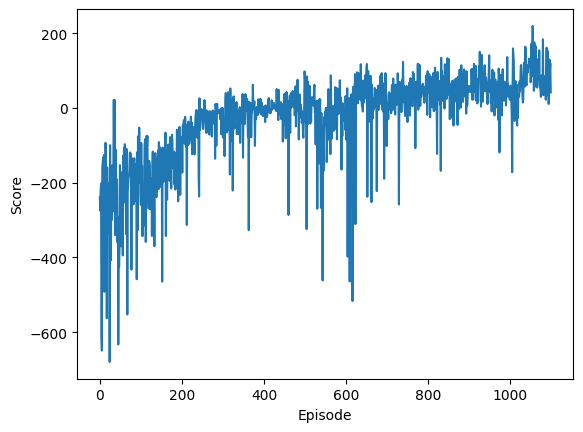

In [ ]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

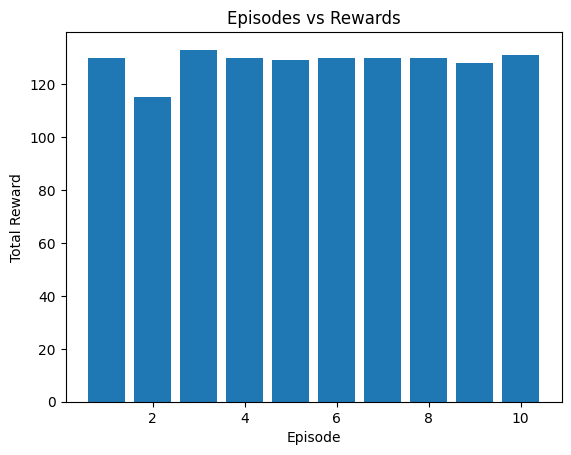

In [ ]:
dummy = [130, 115, 133, 130, 129, 130, 130, 130, 128, 131]

plt.bar([i+1 for i in range(10)], dummy)

plt.title('Episodes vs Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.show()
